In [1]:
import sys
sys.path.append("..")

In [2]:
from src.preprocess.offens_eval import get_X_and_ys
from src.features.sentiment_score_english import sentiment_score_english
from src.features.keras_padded_w2i import get_padded_w2i_matrix

Using TensorFlow backend.


In [3]:
EN_PATH = "../data/raw/OffensEval2019/start-kit/training-v1/offenseval-training-v1.tsv"
data = get_X_and_ys(EN_PATH)
X = data[0]

sentiment_scores = []
for sentence in X:
    sentiment_scores.append(sentiment_score_english(sentence))
print(sentiment_scores)

X_original = X
y = data[1]
y_mapping = data[4]
max_seq_len = 1000
max_num_words = 20000
X, word_index = get_padded_w2i_matrix(X, max_num_words, max_seq_len)

[0, -1, 1, -1, 0, 0, -1, -1, 0, 1, 1, 1, -1, -1, 1, 0, 1, 1, 1, -1, -1, 0, 1, -1, -1, -1, 0, 0, 1, 1, 1, 1, -1, -1, 0, 1, -1, -1, -1, 0, -1, -1, 1, -1, 1, 1, 1, 1, 0, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 0, 0, 0, -1, -1, -1, -1, 0, 1, 1, -1, 1, 0, -1, 0, -1, 0, 0, -1, 0, -1, 1, 0, 1, 1, 1, -1, 1, 1, 0, 0, -1, 1, 0, 1, 1, 1, -1, -1, 1, -1, 0, 1, -1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, -1, 1, 0, 1, -1, 0, 1, 1, 1, 0, -1, -1, 0, -1, -1, -1, 0, -1, 0, -1, 0, 1, 0, -1, -1, 1, -1, 0, 1, -1, 0, 1, -1, 1, -1, 0, -1, -1, 1, -1, 1, 0, 1, -1, 1, 0, -1, 1, -1, 0, -1, 1, 1, 1, -1, 0, 1, 1, 1, 0, 0, 0, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 0, 1, 0, -1, -1, 0, -1, -1, -1, -1, -1, 1, 0, -1, 0, -1, 0, -1, 1, 0, 0, 0, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 0, -1, -1, -1, -1, 1, -1, -1, -1, -1, 0, -1, 1, -1, -1, 1, 0, 1, 1, 1, -1, 0, -1, 1, -1, 1, 1, 0, -1, 1, 1, 1, 1, 1, -1, 0, 1, -1, 0, 1, 1, -1, 0, -1, 1, 1, -1, 0, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 0, -1, 1, 0, 0

In [4]:
from src.features.embedding_matrix import create_embedding_matrix, create_embedding_model
emb_dim = 300
from src.CONSTANTS import EN_EMB_FILE_PATH
emb_model = create_embedding_model("../" +EN_EMB_FILE_PATH)
emb_matrix, num_oov = create_embedding_matrix(
    emb_model, 
    emb_dim,
    word_index
)

from src.layers.pretrained_embedding_layer import get_pretrained_embedding_layer

emb_layer = get_pretrained_embedding_layer(
    len(word_index) + 1,
    emb_dim, 
    emb_matrix,
    max_seq_len,
)

In [17]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.layers import concatenate

main_input = Input(shape=(max_seq_len,), dtype='int32', name='main_input')

x = emb_layer(main_input)

lstm_out = LSTM(10)(x)

auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

In [18]:
import keras 

sent_scores = []
for s in sentiment_scores:
    sent_scores.append([s])
    
auxiliary_input = Input(shape=(1,), name='aux_input')
x = keras.layers.concatenate([lstm_out, auxiliary_input])

x = Dense(8, activation='relu')(x)

In [7]:
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
from src.preprocess.train_test_val_split import train_test_val_split
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y, test_size=0.2, val_size=0.1, random_state=0)
X_aux_train, y_aux_train, X_aux_test, y_aux_test, X_aux_val, y_aux_val = train_test_val_split(sent_scores, y, test_size=0.2, val_size=0.1, random_state=0)

In [16]:
import numpy as np
hist= model.fit([X_train, np.array(X_aux_train)], y_train, epochs=20, batch_size=512)

ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])]...

In [11]:
model.evaluate([X_test, np.array(X_aux_test)], [y_test, y_test])

2648/2648 [==============================] - 19s 7ms/step


[0.9651913934603918, 0.47897531114676206, 0.4862160801527363]

In [12]:
y_pred = model.predict([X_test, np.array(X_aux_test)])
print(len(y_pred))
y_pred = np.array(y_pred).flatten()

2


In [15]:
from src.plotting.confusion_matrix import plot_confusion_matrix
y_pred_binary = [0 if value[0] < 0.5 else 1 for value in y_pred]
plot_confusion_matrix(y_test, y_pred_binary, 2, ["NOT", "OFF"])

5296
2648


IndexError: invalid index to scalar variable.

In [58]:
print(y_pred[0].size)
print(len(y_test))

2648
2648


In [30]:
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam


lstm_input = Input(shape=(max_seq_len,), dtype='int32', name='lstm_input')
lstm = emb_layer(lstm_input)
lstm = LSTM(
        units=10,
        dropout=0.2,
        recurrent_dropout=0.2,
)(lstm)

aux_input = Input(shape=(1,), name='aux_input')
aux = Dense(8)(aux_input)
aux = Dropout(0.2)(aux)

combined_input = concatenate([lstm, aux])

x = Dense(8, activation='relu')(combined_input)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[lstm_input, aux_input], outputs=x)

opt = Adam(lr=1e-3, decay=1e-3 / 200) # Random numbers from some tutorial
model.compile(loss="binary_crossentropy", optimizer=opt)

history = model.fit(
    [X_train, np.array(X_aux_train)],
    y_train,
    epochs=20,
    batch_size=512,
)

preds = model.predict([X_test, np.array(X_aux_test)])

Epoch 1/20
9532/9532 [==============================] - 50s 5ms/step - loss: 0.6814
Epoch 2/20
9532/9532 [==============================] - 48s 5ms/step - loss: 0.6316
Epoch 3/20
9532/9532 [==============================] - 48s 5ms/step - loss: 0.6143
Epoch 4/20
9532/9532 [==============================] - 48s 5ms/step - loss: 0.6053
Epoch 5/20
9532/9532 [==============================] - 48s 5ms/step - loss: 0.6010
Epoch 6/20
9532/9532 [==============================] - 48s 5ms/step - loss: 0.5953
Epoch 7/20
9532/9532 [==============================] - 46s 5ms/step - loss: 0.5808
Epoch 8/20
9532/9532 [==============================] - 47s 5ms/step - loss: 0.5713
Epoch 9/20
9532/9532 [==============================] - 47s 5ms/step - loss: 0.5650
Epoch 10/20
9532/9532 [==============================] - 45s 5ms/step - loss: 0.5586
Epoch 11/20
9532/9532 [==============================] - 44s 5ms/step - loss: 0.5484
Epoch 12/20
9532/9532 [==============================] - 46s 5ms/step - lo

AttributeError: 'list' object has no attribute 'ndim'

In [31]:
preds = model.predict([X_test, np.array(X_aux_test)])

In [32]:
print(hist)

In [34]:
from pprint import pprint
pprint(vars(history))

{'epoch': [0,
           1,
           2,
           3,
           4,
           5,
           6,
           7,
           8,
           9,
           10,
           11,
           12,
           13,
           14,
           15,
           16,
           17,
           18,
           19],
 'history': {'loss': [0.6814157761949178,
                      0.6315740441955842,
                      0.6143256374832166,
                      0.6052591250165891,
                      0.6009697339337662,
                      0.5953107649070397,
                      0.580813473580617,
                      0.5713459424396248,
                      0.5649542421340142,
                      0.5586058782820835,
                      0.5484312699964654,
                      0.540592527744703,
                      0.5373786138077519,
                      0.5330278695104905,
                      0.5229156297442796,
                      0.5231381913368011,
                      0.517364397738793

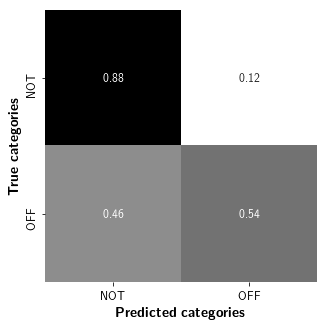

In [39]:
y_pred_binary = [0 if value[0] < 0.5 else 1 for value in preds]
plot_confusion_matrix(y_test, y_pred_binary, 2, ["NOT", "OFF"])

In [42]:
lstm_input = Input(shape=(max_seq_len,), dtype='int32', name='lstm_input')
lstm = emb_layer(lstm_input)
lstm = Bidirectional(
        LSTM(
        units=10,
        dropout=0.2,
        recurrent_dropout=0.2,
), merge_mode="concat")(lstm)

aux_input = Input(shape=(1,), name='aux_input')
aux = Dense(16)(aux_input)
aux = Dropout(0.2)(aux)

combined_input = concatenate([lstm, aux])

x = Dense(16, activation='relu')(combined_input)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[lstm_input, aux_input], outputs=x)

opt = Adam(lr=1e-3, decay=1e-3 / 200) # Random numbers from some tutorial
model.compile(loss="binary_crossentropy", optimizer=opt)

history = model.fit(
    [X_train, np.array(X_aux_train)],
    y_train,
    epochs=40,
    batch_size=512,
)

Epoch 1/40
9532/9532 [==============================] - 84s 9ms/step - loss: 0.6952
Epoch 2/40
9532/9532 [==============================] - 82s 9ms/step - loss: 0.6355
Epoch 3/40
9532/9532 [==============================] - 86s 9ms/step - loss: 0.6126
Epoch 4/40
9532/9532 [==============================] - 83s 9ms/step - loss: 0.6026
Epoch 5/40
9532/9532 [==============================] - 82s 9ms/step - loss: 0.5981
Epoch 6/40
9532/9532 [==============================] - 83s 9ms/step - loss: 0.5932
Epoch 7/40
9532/9532 [==============================] - 88s 9ms/step - loss: 0.5818
Epoch 8/40
9532/9532 [==============================] - 84s 9ms/step - loss: 0.5723
Epoch 9/40
9532/9532 [==============================] - 86s 9ms/step - loss: 0.5631
Epoch 10/40
9532/9532 [==============================] - 88s 9ms/step - loss: 0.5501
Epoch 11/40
9532/9532 [==============================] - 87s 9ms/step - loss: 0.5384
Epoch 12/40
9532/9532 [==============================] - 84s 9ms/step - lo

In [43]:
preds = model.predict([X_test, np.array(X_aux_test)])

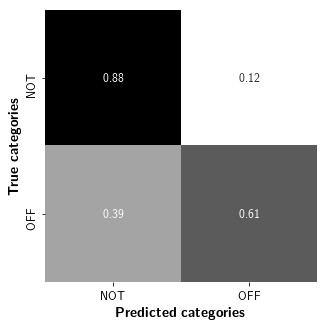

In [44]:
y_pred_binary = [0 if value[0] < 0.5 else 1 for value in preds]
plot_confusion_matrix(y_test, y_pred_binary, 2, ["NOT", "OFF"])